In [182]:
import numpy as np
import pandas as pd

data = pd.read_csv("data/unimelb_training.csv", header=0, dtype="str")
data = data.drop("Unnamed: 251", axis=1)
data["Year"] = data["Start.date"].map(lambda x: float(x.split("/")[2]))
data["Month"] = data["Start.date"].map(lambda x: float(x.split("/")[1]))


numerical_data_feature_category = [
    ("RFCD.Percentage.", 5),
    ("SEO.Percentage.", 5), 
    ("Year.of.Birth.", 15),
    ("Number.of.Successful.Grant.", 15),
    ("Number.of.Unsuccessful.Grant.", 15),
    ("A..", 15),
    ("A.", 15),
    ("B.", 15),
    ("C.", 15)
]

for feature_name, feature_range in numerical_data_feature_category:
    numerical_data_features = [feature_name+str(i) for i in range(1, feature_range+1)]
    for numerical_data_feature in numerical_data_features:
        data[numerical_data_feature] = data[numerical_data_feature].astype(float)

data.dtypes

Grant.Application.ID                        object
Grant.Status                                object
Sponsor.Code                                object
Grant.Category.Code                         object
Contract.Value.Band...see.note.A            object
Start.date                                  object
RFCD.Code.1                                 object
RFCD.Percentage.1                          float64
RFCD.Code.2                                 object
RFCD.Percentage.2                          float64
RFCD.Code.3                                 object
RFCD.Percentage.3                          float64
RFCD.Code.4                                 object
RFCD.Percentage.4                          float64
RFCD.Code.5                                 object
RFCD.Percentage.5                          float64
SEO.Code.1                                  object
SEO.Percentage.1                           float64
SEO.Code.2                                  object
SEO.Percentage.2               

# Contigency for persons

In [183]:
# build the list of all unique values of a given spread column, as a tuple
def process_column(data, prefix, nb_max):
    unique_values = set([])
    for i in range(1, nb_max+1):
        unique_values.update(data[prefix+str(i)].unique())
    return tuple(unique_values)

# Build a dataframe with contingecy frequencies from a given spread column
def add_contigency(prefix, nb_max, unique_values, add_cardinal, keep_nan):
    nb_unique_values = len(unique_values)
    has_nans = np.nan in unique_values
    nan_index = unique_values.index(np.nan)
    new_feature_labels = [prefix+str(value) for value in unique_values]
    if has_nans and not keep_nan:
        new_feature_labels.pop(nan_index)
    if add_cardinal:
        new_feature_labels.append("cardinal_"+prefix)
    def nested_func(x):
        values_frequency = [0]*nb_unique_values
        for i in range(1, nb_max+1):
            values_frequency[unique_values.index(x[prefix+str(i)])] += 1
        if has_nans:
            values_frequency[nan_index] = 0
            if not keep_nan:
                values_frequency.pop(nan_index)
        summe = sum(values_frequency)
        if summe != 0:
            values_frequency = [value/summe for value in values_frequency]
        if add_cardinal:
            values_frequency.append(summe)
        return pd.Series(values_frequency, index=new_feature_labels)
    return nested_func

# Build a dataframe with contingecy frequencies from a given spread column
def build_contigency(data, prefix, nb_max, add_cardinal=False, keep_nan=False):
    unique_values = process_column(data, prefix, nb_max)
    return unique_values, data.apply(add_contigency(prefix, nb_max, unique_values, add_cardinal, keep_nan), axis=1, raw=True)

## Role / Number of years at uni at time of grant / Country of birth

In [184]:
contigency_features_names = []

# Role.
unique_roles, role_contigency_df = build_contigency(data, "Role.", 15, add_cardinal=True)

print(unique_roles)
contigency_features_names.extend(list(role_contigency_df.columns))
data = data.join(role_contigency_df)

# No..of.Years.in.Uni.at.Time.of.Grant.
unique_yearsinuni, yearsinuni_contigency_df = build_contigency(data, "No..of.Years.in.Uni.at.Time.of.Grant.", 15)

print(unique_yearsinuni)
contigency_features_names.extend(list(yearsinuni_contigency_df.columns))
data = data.join(yearsinuni_contigency_df)

# Country.of.Birth.
unique_cob, cob_contigency_df = build_contigency(data, "Country.of.Birth.", 15)

print(unique_cob)
contigency_features_names.extend(list(cob_contigency_df.columns))
data = data.join(cob_contigency_df)

(nan, 'EXTERNAL_ADVISOR', 'HONVISIT', 'STUD_CHIEF_INVESTIGATOR', 'DELEGATED_RESEARCHER', 'CHIEF_INVESTIGATOR', 'STUDRES', 'EXT_CHIEF_INVESTIGATOR', 'PRINCIPAL_SUPERVISOR')
('>=0 to 5', '>10 to 15', '>5 to 10', nan, 'more than 15', 'Less than 0')
(nan, 'The Americas', 'Middle East and Africa', 'Asia Pacific', 'Australia', 'Eastern Europe', 'Great Britain', 'New Zealand', 'Western Europe', 'South Africa', 'North America')


# aggregations for persons

In [185]:
# Build a dataframe with contingecy frequencies from a given spread column
def add_aggregation(prefixes, nb_max):
    feature_names_by_prefix = [[prefix+str(i) for i in range(1, nb_max+1)] for prefix in prefixes]
    methods_to_apply = [np.mean, np.max, np.min]
    new_feature_labels_by_prefix = [[label_prefix+prefix for label_prefix in ["mean_", "max_", "min_"]] for prefix in prefixes]
    flat_new_labels = [new_feature_label for new_feature_labels in new_feature_labels_by_prefix for new_feature_label in new_feature_labels]
    def nested_func(x):
        values_by_prefix = [
            [x[feature_name] for feature_name in feature_names if np.isreal(x[feature_name]) and not np.isnan(x[feature_name])]
            for feature_names in feature_names_by_prefix
        ]
        aggregated_values_by_prefix = [[method(values) for method in methods_to_apply] if len(values) > 0 else [np.nan]*len(methods_to_apply) for values in values_by_prefix]
        return pd.Series(
            data=[aggregated_value for aggregated_values in aggregated_values_by_prefix for aggregated_value in aggregated_values], 
            index=flat_new_labels
        )
    return nested_func
# Build a dataframe with contingecy frequencies from a given spread column
def build_aggregation(data, prefix, nb_max):
    return data.apply(add_aggregation(prefix, nb_max), axis=1, raw=True)

## Year of birth / Number of successful grants / Number of unsuccessfull grants / journals publications (A*, A, B, C)

In [186]:
aggregation_df = build_aggregation(data, ["Year.of.Birth.", "Number.of.Successful.Grant.", "Number.of.Unsuccessful.Grant.", "A..", "A.", "B.", "C."], 15)
aggregation_features_names = list(aggregation_df.columns)

print(aggregation_features_names)
data = data.join(aggregation_df)

['mean_Year.of.Birth.', 'max_Year.of.Birth.', 'min_Year.of.Birth.', 'mean_Number.of.Successful.Grant.', 'max_Number.of.Successful.Grant.', 'min_Number.of.Successful.Grant.', 'mean_Number.of.Unsuccessful.Grant.', 'max_Number.of.Unsuccessful.Grant.', 'min_Number.of.Unsuccessful.Grant.', 'mean_A..', 'max_A..', 'min_A..', 'mean_A.', 'max_A.', 'min_A.', 'mean_B.', 'max_B.', 'min_B.', 'mean_C.', 'max_C.', 'min_C.']


# RFCD & SEO

In [187]:
def rfcd_codes(data, prefix, nb_max, length):
    unique_values = set([])
    for i in range(1, nb_max+1):
        unique_values.update([str(code)[:length] if not np.isreal(code) else np.nan for code in data[prefix+str(i)].unique()])
    return tuple(unique_values)

# Build a dataframe with contingecy frequencies from a given spread column
def add_rfcd_aggregation(prefix1, prefix2, nb_max, unique_values, add_cardinal, suffix, length, keep_nan):
    nb_unique_values = len(unique_values)
    has_nans = np.nan in unique_values
    nan_index = unique_values.index(np.nan)
    new_feature_labels = [prefix2+str(value)+suffix for value in unique_values]
    if has_nans and not keep_nan:
        new_feature_labels.pop(nan_index)
    if add_cardinal:
        new_feature_labels.append("cardinal_"+prefix2)
    def nested_func(x):
        values_percentage = [0]*nb_unique_values
        cardinal = 0
        for i in range(1, nb_max+1):
            considered_value = x[prefix1+str(i)]
            current_value =  np.nan
            if not np.isreal(considered_value) and considered_value != '0':
                current_value = str(considered_value)[:length]
                cardinal += 1
            values_percentage[unique_values.index(current_value)] += x[prefix2+str(i)]/100.0
        if has_nans:
            values_percentage[nan_index] = 0
            if not keep_nan:
                values_percentage.pop(nan_index)
        if add_cardinal:
            values_percentage.append(cardinal)
        return pd.Series(values_percentage, index=new_feature_labels)
    return nested_func

# Build a dataframe with contingecy frequencies from a given spread column
def build_rfcd_aggregation(data, prefix1, prefix2, nb_max, length, add_cardinal=True, suffix="x", keep_nan=False):
    unique_values = rfcd_codes(data, prefix1, nb_max, length)
    return unique_values, data.apply(add_rfcd_aggregation(prefix1, prefix2, nb_max, unique_values, add_cardinal, suffix, length, keep_nan), axis=1, raw=True)

## RFCD / SEO

In [188]:
rfcd_codes_unique, rfcd_df = build_rfcd_aggregation(data, "RFCD.Code.", "RFCD.Percentage.", 5, 2)

rfcd_features_names = list(rfcd_df.columns)
print(rfcd_codes_unique)
print(rfcd_features_names)
data = data.join(rfcd_df)

seo_codes_unique, seo_df = build_rfcd_aggregation(data, "SEO.Code.", "SEO.Percentage.", 5, 2)

seo_features_names = list(seo_df.columns)
print(seo_codes_unique)
print(seo_features_names)
data = data.join(seo_df)

(nan, '39', '33', '30', '26', '31', '36', '41', '32', '28', '23', '25', '44', '21', '99', '35', '29', '34', '0', '24', '43', '42', '37', '27', '38', '40')
['RFCD.Percentage.39x', 'RFCD.Percentage.33x', 'RFCD.Percentage.30x', 'RFCD.Percentage.26x', 'RFCD.Percentage.31x', 'RFCD.Percentage.36x', 'RFCD.Percentage.41x', 'RFCD.Percentage.32x', 'RFCD.Percentage.28x', 'RFCD.Percentage.23x', 'RFCD.Percentage.25x', 'RFCD.Percentage.44x', 'RFCD.Percentage.21x', 'RFCD.Percentage.99x', 'RFCD.Percentage.35x', 'RFCD.Percentage.29x', 'RFCD.Percentage.34x', 'RFCD.Percentage.0x', 'RFCD.Percentage.24x', 'RFCD.Percentage.43x', 'RFCD.Percentage.42x', 'RFCD.Percentage.37x', 'RFCD.Percentage.27x', 'RFCD.Percentage.38x', 'RFCD.Percentage.40x', 'cardinal_RFCD.Percentage.']
(nan, '76', '66', '73', '70', '0', '72', '77', '64', '78', '63', '71', '69', '65', '61', '67', '99', '74', '68', '62', '75')
['SEO.Percentage.76x', 'SEO.Percentage.66x', 'SEO.Percentage.73x', 'SEO.Percentage.70x', 'SEO.Percentage.0x', 'SEO.P

# Building dataset

## Setting train and test sets

## Filling NAs

In [189]:
# filling NAs with mean
for feature_name in aggregation_features_names:
    # FROM nonmean to nanmedian !!!!
    data[feature_name] = data[feature_name].fillna(np.nanmedian(data[feature_name]))

# filling NAs with other value
data['Sponsor.Code'] = data['Sponsor.Code'].fillna('MIA')
data['Grant.Category.Code'] = data['Grant.Category.Code'].fillna('MIA')

# Reducing number of categories
sponsor_reduced_codes = set(data['Sponsor.Code'].value_counts().index[:10])
data['Sponsor.Code.Reduced'] = data['Sponsor.Code'].map(lambda x: x if x in sponsor_reduced_codes else 'Other')
    
grant_cat_reduced_codes = set(data['Grant.Category.Code'].value_counts().index[:9])
data['Grant.Category.Code.Reduced'] = data['Grant.Category.Code'].map(lambda x: x if x in grant_cat_reduced_codes else 'Other')

# Dummy variables for categorical data

In [190]:
# Sponsor.Code.Reduced
sponsor_reduced_dummies = pd.get_dummies(data["Sponsor.Code.Reduced"], prefix="Sponsor.Code.Reduced")
sponsor_reduced_dummies_features = list(sponsor_reduced_dummies.columns)
data = data.join(sponsor_reduced_dummies)

# Grant.Category.Code.Reduced
grant_cat_reduced_dummies = pd.get_dummies(data["Grant.Category.Code.Reduced"], prefix="Grant.Category.Code.Reduced")
grant_cat_reduced_dummies_features = list(grant_cat_reduced_dummies.columns)
data = data.join(grant_cat_reduced_dummies)

## Trying to fill Contract.Value.Band...see.note.A NaNs

In [ ]:
data['Contract.Value.Band...see.note.A'] = data['Contract.Value.Band...see.note.A'].fillna('MIA')

withCVB, withoutCVB = data.loc[data['Contract.Value.Band...see.note.A'] != "MIA"], data.loc[data['Contract.Value.Band...see.note.A'] == "MIA"]
len(withCVB), len(withoutCVB)



application_feature_names = [
    "Grant.Application.ID", 
    "Grant.Status", 
    "Sponsor.Code", 
    "Grant.Category.Code", 
    "Contract.Value.Band...see.note.A", 
    "Start.date",
    "Year",
    "Month"
]

features_without_nan = list(np.concatenate([
            application_feature_names 
            + contigency_features_names 
            + aggregation_features_names 
            + rfcd_features_names 
            + seo_features_names
            + sponsor_reduced_dummies_features
            + grant_cat_reduced_dummies_features
            + grant_cat_letter_dummies_features
            + grant_cat_number_dummies_features
            + sponsor_code_letter_dummies_features
        ]))

features_without_nan.remove("Sponsor.Code")
features_without_nan.remove("Grant.Category.Code")
features_without_nan.remove("Contract.Value.Band...see.note.A")

# Not to be used for classification
features_without_nan.remove("Grant.Application.ID")
features_without_nan.remove("Grant.Status")
features_without_nan.remove("Start.date")




from sklearn.cross_validation import train_test_split

X_train_CVB, X_test_CVB, y_train_CVB, y_test_CVB = train_test_split(withCVB[features_without_nan], withCVB["Contract.Value.Band...see.note.A"].astype("category").cat.codes, test_size=0.3, random_state=0)
len(X_train_CVB), len(X_test_CVB)



from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1600, n_jobs = 7)
classifierRF = rf.fit(X_train_CVB, y_train_CVB)
predictionRF = classifierRF.predict(X_test_CVB)
prediction_probaRF = classifierRF.predict_proba(X_test_CVB)

print("Accuracy: %f" % (accuracy_score(y_test_CVB, predictionRF)))

print("\nFeatures importances:")
feature_importances = list(zip(features_without_nan, classifierRF.feature_importances_))
feature_importances.sort(key=lambda x:x[1], reverse=True)
for name, importance in feature_importances:
    print("%50s: %f" %(name, importance))
    
    
    
(np.max(prediction_probaRF, axis=1) > 0.5).sum()

In [ ]:
contract_value_reduced_codes = set(data['Contract.Value.Band...see.note.A'].value_counts().index[:8])
data['Contract.Value.Band...see.note.A.Reduced'] = data['Contract.Value.Band...see.note.A'].map(lambda x: x if x in contract_value_reduced_codes else 'Other')

# Contract.Value.Band...see.note.A.Reduced
contract_value_reduced_dummies = pd.get_dummies(data["Contract.Value.Band...see.note.A.Reduced"], prefix="Contract.Value.Band...see.note.A.Reduced")
contract_value_reduced_dummies_features = list(contract_value_reduced_dummies.columns)
data = data.join(contract_value_reduced_dummies)

## Contract.Value.Band.Values

In [191]:
# contract_value_band_values = {
#     "A": [1, 50000],
#     "B" : [50001, 100000],
#     "C" : [100001, 200000],
#     "D" : [200001, 300000],
#     "E" : [300001, 400000],
#     "F" : [400001, 500000],
#     "G" : [500001, 1000000],
#     "H" : [1000001, 2000000],
#     "I" : [2000001, 3000000],
#     "J" : [3000001, 4000000],
#     "K" : [4000001, 5000000],
#     "L" : [5000001, 6000000],
#     "M" : [6000001, 7000000],
#     "N" : [7000001, 8000000],
#     "O" : [8000001, 9000000],
#     "P" : [9000001, 10000000],
#     "Q" : [10000001, 100000000]
# }

# for letter, values in contract_value_band_values.items():
#     # The mean is divided by 100000.0 for avoiding de-normalization
#     values.append(np.mean(values) / 100000.0)

# def assign_value(x):
#     if x is not 'MIA':
#         return contract_value_band_values[x.strip()][2]
#     return np.nan

# data["Contract.Value.Band.Values"] = data["Contract.Value.Band...see.note.A"].map(assign_value)
# data["Contract.Value.Band.Values"] = data["Contract.Value.Band.Values"].fillna(np.nanmedian(data["Contract.Value.Band.Values"]))

In [192]:

contract_value_band_values = {
    "A": [1, 50000],
    "B" : [50001, 100000],
    "C" : [100001, 200000],
    "D" : [200001, 300000],
    "E" : [300001, 400000],
    "F" : [400001, 500000],
    "G" : [500001, 1000000],
    "H" : [1000001, 2000000],
    "I" : [2000001, 3000000],
    "J" : [3000001, 4000000],
    "K" : [4000001, 5000000],
    "L" : [5000001, 6000000],
    "M" : [6000001, 7000000],
    "N" : [7000001, 8000000],
    "O" : [8000001, 9000000],
    "P" : [9000001, 10000000],
    "Q" : [10000001, 100000000]
}

for letter, values in contract_value_band_values.items():
    # The mean is divided by 100000.0 for avoiding de-normalization
    values.append(np.mean(values) / 100000.0)

def assign_value(x):
    if x["Contract.Value.Band...see.note.A"] is not 'MIA':
        return contract_value_band_values[x["Contract.Value.Band...see.note.A"].strip()][2]
    elif x["Sponsor.Code"] in ("2B", "4D"):
        return contract_value_band_values["A"][2]
    return np.nan

data["Contract.Value.Band.Values"] = data.apply(assign_value, axis=1)
data["Contract.Value.Band.Values"] = data["Contract.Value.Band.Values"].fillna(np.nanmedian(data["Contract.Value.Band.Values"]))

# print(data.apply(assign_value, axis=1).isnull().sum())
# data["Contract.Value.Band.Values"] = data["Contract.Value.Band.Values"].fillna(np.nanmedian(data["Contract.Value.Band.Values"]))

## Grant category Code

In [193]:
data["Grant.Category.Code.Letter"] = data["Grant.Category.Code"].map(lambda x: x[-1] if x != 'MIA' else "Unknown")

grant_cat_letter_dummies = pd.get_dummies(data["Grant.Category.Code.Letter"], prefix="Grant.Category.Code.Letter")
grant_cat_letter_dummies_features = list(grant_cat_letter_dummies.columns)
data = data.join(grant_cat_letter_dummies)

data["Grant.Category.Code.Number"] = data["Grant.Category.Code"].map(lambda x: x[:-1] if x != 'MIA' else "Unknown")

grant_cat_number_dummies = pd.get_dummies(data["Grant.Category.Code.Number"], prefix="Grant.Category.Code.Number")
grant_cat_number_dummies_features = list(grant_cat_number_dummies.columns)
data = data.join(grant_cat_number_dummies)

## Sponsor Code

In [194]:
data["Sponsor.Code.Letter"] = data["Sponsor.Code"].map(lambda x: x[-1] if x != 'MIA' else "Unknown")

sponsor_code_letter_dummies = pd.get_dummies(data["Sponsor.Code.Letter"], prefix="Sponsor.Code.Letter")
sponsor_code_letter_dummies_features = list(sponsor_code_letter_dummies.columns)
data = data.join(sponsor_code_letter_dummies)

## Choosing the features

In [195]:
application_feature_names = [
    "Grant.Application.ID", 
    "Grant.Status", 
    "Sponsor.Code", 
    "Grant.Category.Code", 
    "Contract.Value.Band...see.note.A", 
    "Start.date",
    "Year",
    "Month",
    "Contract.Value.Band.Values"
]

features_without_nan = list(np.concatenate([
            application_feature_names 
            + contigency_features_names 
            + aggregation_features_names 
            + rfcd_features_names 
            + seo_features_names
            + sponsor_reduced_dummies_features
            + grant_cat_reduced_dummies_features
            + contract_value_reduced_dummies_features
            + grant_cat_letter_dummies_features
            + grant_cat_number_dummies_features
            + sponsor_code_letter_dummies_features
        ]))

features_without_nan.remove("Sponsor.Code")
features_without_nan.remove("Grant.Category.Code")
features_without_nan.remove("Contract.Value.Band...see.note.A")
# features_without_nan.remove("mean_Year.of.Birth.")
# features_without_nan.remove("mean_Number.of.Successful.Grant.")
# features_without_nan.remove("mean_Number.of.Unsuccessful.Grant.")
# features_without_nan.remove("mean_A..")
# features_without_nan.remove("mean_A.")
# features_without_nan.remove("mean_B.")
# features_without_nan.remove("mean_C.")

# Not to be used for classification
features_without_nan.remove("Grant.Application.ID")
features_without_nan.remove("Grant.Status")
features_without_nan.remove("Start.date")

data[features_without_nan].isnull().sum()

Year                                                 0
Month                                                0
Contract.Value.Band.Values                           0
Role.EXTERNAL_ADVISOR                                0
Role.HONVISIT                                        0
Role.STUD_CHIEF_INVESTIGATOR                         0
Role.DELEGATED_RESEARCHER                            0
Role.CHIEF_INVESTIGATOR                              0
Role.STUDRES                                         0
Role.EXT_CHIEF_INVESTIGATOR                          0
Role.PRINCIPAL_SUPERVISOR                            0
cardinal_Role.                                       0
No..of.Years.in.Uni.at.Time.of.Grant.>=0 to 5        0
No..of.Years.in.Uni.at.Time.of.Grant.>10 to 15       0
No..of.Years.in.Uni.at.Time.of.Grant.>5 to 10        0
No..of.Years.in.Uni.at.Time.of.Grant.more than 15    0
No..of.Years.in.Uni.at.Time.of.Grant.Less than 0     0
Country.of.Birth.The Americas                        0
Country.of

## Splitting into train and test

In [196]:
# Fetching ids from files
testing_ids = pd.read_csv("data/testing_ids.csv")["ids"].values
training2_ids = pd.read_csv("data/training2_ids.csv")["ids"].values

# Setting index
data_ids = data["Grant.Application.ID"].astype(int).values
training_ids = np.setdiff1d(data_ids, testing_ids)
training1_ids = np.setdiff1d(training_ids, training2_ids)

train_df = data.loc[training_ids-1]
train1_df = data.loc[training1_ids-1]
train2_df = data.loc[training2_ids-1]
test_df = data.loc[testing_ids-1]

# Exporting files
# train_df.to_csv("data/train.csv")
# train1_df.to_csv("data/train1.csv")
# train2_df.to_csv("data/train2.csv")
# test_df.to_csv("data/test.csv")

## X_train, X_test, y_train, y_test

In [197]:
X_train, X_test = train_df[features_without_nan], test_df[features_without_nan]
y_train, y_test = train_df["Grant.Status"].astype(int), test_df["Grant.Status"].astype(int)

## Logistic Regression

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Predictions
classifier_log = LogisticRegression().fit(X_train, y_train)
prediction_log = classifier_log.predict(X_test)
prediction_proba_log = classifier_log.predict_proba(X_test)

print("Accuracy: %f | AUC: %f" % (accuracy_score(y_test, prediction_log), roc_auc_score(np.array(y_test.values), prediction_proba_log[:, 1])))

# print("\nFeatures coefficients:")
# features_coef = list(zip(features_without_nan, classifier_log.coef_[0,:]))
# features_coef.sort(key=lambda x:x[1], reverse=True)
# for name, coef in features_coef:
#     print("%50s: %f" %(name, coef))

Accuracy: 0.847490 | AUC: 0.907576


## Random Forest

In [199]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1600, n_jobs = 7)
classifierRF = rf.fit(X_train, y_train)
predictionRF = classifierRF.predict(X_test)
prediction_probaRF = classifierRF.predict_proba(X_test)

print("Accuracy: %f | AUC: %f" % (accuracy_score(y_test, predictionRF), roc_auc_score(np.array(y_test.values), prediction_probaRF[:, 1])))

print("\nFeatures importances:")
feature_importances = list(zip(features_without_nan, classifierRF.feature_importances_))
feature_importances.sort(key=lambda x:x[1], reverse=True)
for name, importance in feature_importances:
    print("%50s: %f" %(name, importance))

Accuracy: 0.888031 | AUC: 0.960631

Features importances:
      Contract.Value.Band...see.note.A.Reduced_MIA: 0.085673
                mean_Number.of.Unsuccessful.Grant.: 0.084365
                 max_Number.of.Unsuccessful.Grant.: 0.074647
                        Contract.Value.Band.Values: 0.042507
                  mean_Number.of.Successful.Grant.: 0.039205
                 min_Number.of.Unsuccessful.Grant.: 0.036452
                                             Month: 0.035905
                   max_Number.of.Successful.Grant.: 0.035640
                   min_Number.of.Successful.Grant.: 0.024354
                                              Year: 0.023782
       Contract.Value.Band...see.note.A.Reduced_A : 0.018486
                                           mean_A.: 0.013478
                                           mean_B.: 0.013162
                                            max_B.: 0.012592
                                            max_A.: 0.012554
                           

## ROC curves

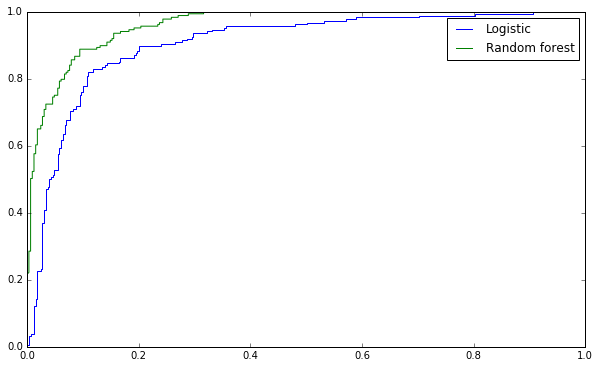

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr_log, tpr_log, thresholds_log = roc_curve(np.array(y_test.values), prediction_proba_log[:, 1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.array(y_test.values), prediction_probaRF[:, 1])

plt.figure(figsize=(10,6))
plt.plot(fpr_log, tpr_log, 'b', label='Logistic')
plt.plot(fpr_rf, tpr_rf, 'g', label='Random forest')
plt.legend(loc=0)
plt.show()

# Parameters tuning (Grid Search)

In [ ]:
from sklearn.grid_search import GridSearchCV

parameters = {'n_estimators': [i for i in range(500, 1300, 100)], 'max_features': [i for i in range(1, 10)]}
GridsearchSVM = GridSearchCV(RandomForestClassifier(), parameters, cv=3, verbose=10, scoring='roc_auc', n_jobs=7)
GridsearchSVM.fit(X_train, y_train)

print(GridsearchSVM.best_params_, GridsearchSVM.best_score_)

# roc_auc_score(np.array(y_test.values), GridsearchSVM.best_estimator_.predict_proba(X_test)[:, 1])
# roc_auc_score(np.array(y_test.values), GridsearchSVM.best_estimator_.fit(X_train, y_train).predict_proba(X_test)[:, 1])

In [20]:
from sklearn.grid_search import ParameterGrid

def grid_search_no_cv(parameters, X_train, X_test, y_train, y_test):

    grid_search = ParameterGrid(parameters)
    best_score = 0
    best_params = {}

    nb_gridsearch_folds = len(grid_search)
    for index, param in enumerate(grid_search):
        prediction_proba = RandomForestClassifier(**param, n_jobs=7).fit(X_train, y_train).predict_proba(X_test)
        current_score = roc_auc_score(np.array(y_test.values), prediction_proba[:, 1])
        flag_best = " "
        if current_score > best_score:
            best_score = current_score
            best_params = param
            flag_best = "*"
        print(flag_best+" %2d/%d | %f | %s" %(index+1, nb_gridsearch_folds, current_score, str(param)))
    return best_score, best_params

In [ ]:
X_train1, X_train2 = train1_df[features_without_nan], train2_df[features_without_nan]
y_train1, y_train2 = train1_df["Grant.Status"].astype(int), train2_df["Grant.Status"].astype(int)

parameters = {'n_estimators': [i for i in range(2000, 3000, 200)], 'max_features': [i for i in range(8, 14)]}

best_score, best_params = grid_search_no_cv(parameters, X_train1, X_train2, y_train1, y_train2)

In [74]:
parameters = {'n_estimators': [i for i in range(500, 3500, 100)]}

best_score, best_params = grid_search_no_cv(parameters, X_train, X_test, y_train, y_test)

*  1/30 | 0.958621 | {'n_estimators': 500}
*  2/30 | 0.960197 | {'n_estimators': 600}
*  3/30 | 0.960229 | {'n_estimators': 700}
   4/30 | 0.960141 | {'n_estimators': 800}
   5/30 | 0.958854 | {'n_estimators': 900}
   6/30 | 0.959152 | {'n_estimators': 1000}
*  7/30 | 0.960703 | {'n_estimators': 1100}


KeyboardInterrupt: 